# ASTRON 3580 Problem Set 5
### Helena Richie, April 1st, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy import units as u
from astropy.wcs import WCS
import glob
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib import use
import numpy as np
import os
from photutils import aperture_photometry
import photutils.centroids as c
from photutils import DAOStarFinder
from photutils import SkyCircularAperture, SkyCircularAnnulus
from IPython import display

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_counts(dirtarget, ra, dec, fil, aper_rad, ann_in_rad, ann_out_rad,
               name, date, set_rad=False, centroid_plot=False):
    """Generates background-substracted aperture sums for a source in an image.

    Defines source region as a 20x20 square centered at the input R.A. and dec.
    Source region is checked to ensure it is below the CCD saturation level,
    and lies entirely in the image. Centroiding is then performed to locate the
    central pixel of the source. An aperture and annulus are placed around this
    pixel and the background-subtracted aperture sum is calculated. All returns
    have size (#source(s) x #image(s)).

    Parameters
    ----------
    dirtarget : str
        Directory containing all bias, flat, and raw science images.
    ra : list
        List of string(s) of right ascension(s) of object(s) to be processed.
    dec : list
        List of string(s) of declination(s) of object(s) to be processed.
    fil : str
        Name of filter used for images which are currently being processed.
    aper_rad : float
        User-specified aperture radius in arcseconds.
    ann_in_rad : float
        User-specified annulus inner radius in arcseconds.
    ann_out_rad : float
        User-specified annulus outer radius in arcseconds.
    name : str
        Object type that get_counts is being ran on (e.g. target, comp, check).
    date : str
        Date of observation.
    set_rad : Boolean
        Determine whether user would like to use default aperture/annulus radii
        or specify their own.
    centroid_plot : Boolean
        Whether or not to plot centroid shifts for object.

    Returns
    -------
    aper_sum : numpy.ndarray
        Array of floats corresponding to aperture sums of each source.
    err : numpy.ndarray
        Array of floats corresponding to uncertainty of each aperture sum.
    date_obs : numpy.ndarray
        Array of floats corresponding to Julian Date of each image.
    altitudes : numpy.ndarray
        Array of floats corresponding to the altitude of each image.
    saturated : list
        List of list(s) containing the file path of any image whose source
        meets or exceeds the expected saturation level.
    exptimes : numpy.ndarray
        Array of floats corresponding to exposure time of each image.
    init_coords : numpy.ndarray
        Array of strings corresponding to the pixel coordinates (x,y) of the
        R.A. and dec. of the image's source, according to its WCS solution.
    cent_coords : numpy.ndarray
        Array of strings corresponding to the central pixel coordinates (x,y)
        of the centroided aperture. If the centroid routine failed, the string
        'init' is returned for that image.
    image_num : numpy.ndarray
        Array of integers containing the number of each image in dirtarget.
    sat_qual : numpy.ndarray
        Data quality mask that contains 0s for images that do not have a
        saturated source and 1s for source that do.
    cent_qual : numpy.ndarray
        Data quality mask that contains 0s for images with successful aperture
        centroiding and 1s for images with failed centoiding or poor WCS
        solutions.
    """
    dirtarget_wcs = os.path.join(dirtarget, "ISR_Images", fil, "WCS")
    files = sorted(glob.glob(os.path.join(dirtarget_wcs, '*.fits')))
    size_files = len(files)
    size_sources = len(ra)

    # Initialize output arrays.
    # Dimensions: #sources x #(images in dirtarget)
    aper_sum = np.empty([size_sources, size_files], dtype=float)
    aper_sum[:][:] = np.nan
    err = np.empty([size_sources, size_files], dtype=float)
    err[:][:] = np.nan
    date_obs = np.empty([size_sources, size_files], dtype=float)
    date_obs[:][:] = np.nan
    altitudes = np.empty([size_sources, size_files], dtype=float)
    altitudes[:][:] = np.nan
    saturated = []
    exptimes = np.empty([size_sources, size_files], dtype=float)
    exptimes[:][:] = np.nan
    init_coords = np.empty([size_sources, size_files], dtype=object)
    init_coords[:][:] = 'init'
    cent_coords = np.empty([size_sources, size_files], dtype=object)
    cent_coords[:][:] = 'init'
    image_num = np.empty([size_sources, size_files], dtype=object)
    image_num[:][:] = 'init'
    pix_radius = np.empty(size_sources, dtype=float)
    pix_radius[:] = np.nan
    image_arr = np.empty([size_sources, size_files], dtype=float)
    image_arr[:][:] = np.nan
    sat_qual = np.empty([size_sources, size_files], dtype=int)
    sat_qual[:][:] = 0
    cent_qual = np.empty([size_sources, size_files], dtype=int)
    cent_qual[:][:] = 0

    i = 0
    for i, (ra_i, dec_i) in enumerate(zip(ra, dec)):
        print('\nProcessing {} star ({})...'.format(name, fil))
        

        im = None
        p1 = None
        p2 = None
        circ = None
        fig = None
        ax = None
        pix_radius = None

        saturated_i = []

        # Initialize nine evenly-spaced indices to plot a centroiding summary.
        cent_ind = np.linspace(0, size_files-1, 9).astype(int)
        if centroid_plot:
            fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
            ax = ax.flatten()
            for k in range(0, 9):
                ax[k].set_title('Image {}'.format(cent_ind[k]), size=10)
                for l in (ax[k].get_xticklabels() + ax[k].get_yticklabels()):
                    l.set_fontsize(8)

        # fig_anim, ax_anim = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
        # im_anim = plt.imshow()
        # def animate(i):
        for j, item in enumerate(files):
            o_file = os.path.join(item)
            hdulist = fits.open(o_file)
            header = hdulist[0].header
            data = hdulist[0].data
            
            
            header['CTYPE1'] = "RA---TAN-SIP"
            header['CTYPE2'] = "DEC--TAN-SIP"
            
            im_str = str(o_file)
            im_n = im_str[-10:-7]
            try:
                int(im_n)
            except ValueError:
                im_n = j

            image_num[i][j] = im_n

            # Read output information from header of image being processed.
            exptimes[i][j] = float(header['EXPTIME'])
            date_j = header['DATE-OBS']
            t = Time(date_j)
            time = t.jd
            date_obs[i][j] = float(time)
            altitudes[i][j] = float(header['OBJCTALT'])

            # Check if WCS solution was successful.
            if header['WCSMATCH'] < 10:
                print('\nLess than 10 stars matched in WCS calculation.')
                cent_qual[i][j] = 1
                continue

            # Find pixel location of R.A. and dec. according to WCS solution
            w = WCS(header)
            coords = SkyCoord(ra_i, dec_i, unit=(u.hourangle, u.deg))
            px_dec, py_dec = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1)
            px, py = int(px_dec), int(py_dec)
            init_coords_pix = (px, py)
            init_coords[i][j] = ','.join(map(str, init_coords_pix))

            # Define source region as a 20x20 square centered at (px,py)
            star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

            # Get image dimensions from the header
            x_dim = int(header['NAXIS1'])
            y_dim = int(header['NAXIS2'])

            # Check that region lies entirely within image.
            if ((py - 19) < 0) or ((py + 21) > y_dim):
                print('\n{} star not entirely in the image for'.format(name) +
                      ' image number {}'.format(im_n))
                cent_qual[i][j] = 1
                continue
            if ((px - 19) < 0) or ((px + 21) > x_dim):
                print('\n{} star not entirely in the image for'.format(name) +
                      ' image number {}'.format(im_n))
                cent_qual[i][j] = 1
                continue

            star_flat = star.reshape(1, len(star) * len(star[0]))

            # Check that source does not exceed the expected saturation level.
            max_pix = int(np.amax(star_flat))
            if max_pix >= header['SATLEVEL']:
                print('\n{} star met or exceeded saturation '.format(name) +
                      'level for image number {}.'.format(im_n))
                print('\nSaturation value: {}'.format(header['SATLEVEL']))
                print('\nMax aperture value: {}'.format(max_pix))
                saturated_i.append(item)
                sat_qual[i][j] = 1
                continue

            # Peform aperture centroiding for the source.
            # If centroiding failed, then move onto the next image.
            FWHM = 4
            try:
                mean, median, std = sigma_clipped_stats(star, sigma=3.0)
                daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std)
                sources = daofind(star - median)
                px_cent = np.average(sources['xcentroid'])
                py_cent = np.average(sources['ycentroid'])
            except TypeError:
                print('\nCentroiding failed for image {}.'.format(im_n))
                cent_qual[i][j] = 1
                continue

            # Return centroided pixel coordinates.
            x_cent = int(px - 19 + px_cent)
            y_cent = int(py - 19 + py_cent)

            cent_coords_pix = (x_cent, y_cent)
            cent_coords[i][j] = ','.join(map(str, cent_coords_pix))

            cent_equa = SkyCoord.from_pixel(x_cent, y_cent, w)

            # Define aperture and annulus radii.
            radius = None
            r_in = None
            r_out = None
            if set_rad:
                radius = float(aper_rad) * u.arcsec
                r_in = float(ann_in_rad) * u.arcsec
                r_out = float(ann_out_rad) * u.arcsec

            else:
                radius = 4 * u.arcsec
                r_in = 25 * u.arcsec
                r_out = 27 * u.arcsec

            # Create SkyCircularAperture and SkyCircularAnnulus objects
            # centered at the position of the star whose counts are being
            # summed.
            aperture = SkyCircularAperture(cent_equa, radius)
            annulus = SkyCircularAnnulus(cent_equa, r_in=r_in, r_out=r_out)

            apers = (aperture, annulus)

            secpix1 = abs(hdulist[0].header['SECPIX1'])

            # Determine the area of the aperture and annulus using the
            # arcseconds per pixel in the horizontal dimension header keyword.
            aper_area = np.pi * (radius / secpix1) ** 2
            area_out = np.pi * (r_out / secpix1) ** 2
            area_in = np.pi * (r_in / secpix1) ** 2
            annulus_area = area_out - area_in

            pix_radius = radius.value / secpix1

            # Call aperture_photometry function in order to sum all of the
            # counts in both the aperture and annulus for item.
            phot_table = aperture_photometry(hdulist[0].data, apers, wcs=w)

            # Remove the background level from the aperture sum.
            bkg_mean = phot_table['aperture_sum_1'] / annulus_area
            bkg_sum = bkg_mean * aper_area
            final_sum = phot_table['aperture_sum_0'] - bkg_sum
            phot_table['residual_aperture_sum'] = final_sum

            # Determine the error in the aperture sum and background level.
            # source_err = np.sqrt(phot_table['residual_aperture_sum'])
            source = phot_table['residual_aperture_sum']

            aper_sum[i][j] = phot_table['residual_aperture_sum'][0]
            err[i][j] = np.sqrt(source + bkg_sum)

            j_plot = np.where(cent_ind == j)[0]
            if centroid_plot:
                if j in cent_ind:
                    j_plot = j_plot[0]
                    p1 = ax[j_plot].scatter([px+1], [py+1], c="thistle",
                                            label="Original",
                                            edgecolors='mistyrose')
                    p2 = ax[j_plot].scatter([x_cent+1], [y_cent+1],
                                            c="rebeccapurple",
                                            label="Corrected",
                                            edgecolors='mistyrose')
                    im = ax[j_plot].imshow(star, extent=(px - 19, px + 21,
                                                         py - 19, py + 21),
                                           cmap='magma', origin='lower')
                    ax[j_plot].set_title('Image {}'.format(im_n), size=10)
                    circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
                                  fill=False, label='Aperture', ls='-',
                                  color='mistyrose')
                    ax[j_plot].add_patch(circ)
                    for label in (ax[j_plot].get_xticklabels() +
                                  ax[j_plot].get_yticklabels()):
                        label.set_fontsize(8)


            hdulist.close()
            del data

        saturated.append(saturated_i)

        if centroid_plot:
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            cb = fig.colorbar(im, cax=cbar_ax)
            plt.setp(cb.ax.get_yticklabels(), fontsize=8)

            plt.figlegend([p1, p2, circ], ['Original', 'Corrected', 'Aperture'],
                          fontsize=14)
            fig.suptitle('Aperture Centroiding on {}, {}'.format(ra_i, dec_i),
                         fontsize=16)
            fig.text(0.5, 0.04, 'x [pixel]', ha='center')
            fig.text(0.04, 0.5, 'y [pixel]', va='center', rotation='vertical')
            if name == 'comp':
                out_file = os.path.join('centroid_{}{}_{}_{}.pdf'.format(name,
                                                                         i+1,
                                                                         date,
                                                                         fil))
            else:
                out_file = os.path.join('centroid_{}_{}_{}.pdf'.format(name,
                                                                       date,
                                                                       fil))

            plt.savefig(os.path.join(dirtarget, "ISR_Images", fil, "WCS",
                                     'output', out_file))
            
        i += 1

    return aper_sum, err, date_obs, altitudes, saturated, exptimes, \
        init_coords, cent_coords, image_num, sat_qual, cent_qual


In [3]:
def photometry(dirtarget, fil, coords, comp_ra, comp_dec, cra, cdec, comp_mags,
               aper_rad, ann_in_rad, ann_out_rad, date, set_rad=False):
    """Gets aperture sums for target, comparison, and check stars.

    Calls get_counts for the list of right ascension(s) and declination(s) for
    the target star, each comparison star, and the check star.
    The err, date_obs, and altitudes are defined when get_counts is
    called for the target star. Then, if any of the comparison stars are not
    image (i.e. they have either nan or negative values in their aper_sum
    in the arrays), then they are removed from the comp_aper_sum array and the
    corresponding magnitude is removed from comp_mags. The same process is
    repreated for the check and star, except there is no corresponding
    magnitude to delete.

    Parameters
    ----------
    dirtarget : str
        Directory containing all bias, flat, and raw science images.
    fil : list
        List containing string of each filter keyword found in header of flat
        field and light frame images.
    coords : list
        List of list of string of target right ascension and declination.
    comp_ra : list
        List of strings of comparison stars' right ascension.
    comp_dec : list
        List of strings of comparison stars' declination.
    cra : list
        List of string of right ascension of check star.
    cdec : list
        List of string of delination of check star.
    comp_mags : list
        List of floats representing the magnitudes of the comparison stars.
    aper_rad : float
        User-specified aperture radius in arcseconds.
    ann_in_rad : float
        User-specified annulus inner radius in arcseconds.
    ann_out_rad : float
        User-specified annulus outer radius in arcseconds.
    date : str
        Date of observation.
    set_rad : Boolean
        Determine whether user would like to use default aperture/annulus radii
        or specify their own.

    Returns
    -------
    aper_sum : numpy.ndarray
        Array of floats corresponding to aperture sums of target star.
    comp_apers_return : numpy.ndarray
        Array of arrays of aperture sum floats for each comparison star.
    check_apers : numpy.ndarray
        Array of floats corresponding to aperture sums of check star.
    err : numpy.ndarray
        Array of floats corresponding to uncertainty of each aperture sum.
    check_err : numpy.ndarray
        Array of floats corresponding to uncertainty of each aperture sum of the check star.
    date_obs : numpy.ndarray
        Array of floats corresponding to Julian Date of each image.
    altitudes : numpy.ndarray
        Array of floats corresponding to the altitude of each image.
    comp_mags : numpy.ndarray
        Array of floats of comparison star magnitudes.
    saturated : list
        List of strings containing the file path of any image whose source
        meets or exceeds the expected saturation level.
    exposure_times : numpy.ndarray
        Array of floats corresponding to exposure time of each image.
    centroid_coords : numpy.ndarray
        Array of strings corresponding to the central pixel coordinates (x,y)
        of the centroided aperture. If the centroid routine failed, the string
        'init' is returned for that image.
    init_coord_list : numpy.ndarray
        Array of strings corresponding to the pixel coordinates (x,y) of the
        R.A. and dec. of the image's source, according to its WCS solution.
    image_num : numpy.ndarray
        Array of integers containing the number of each image in dirtarget.
    """
    # Get aperture sum, error of aperture sum, times of data collection,
    # and altitudes for target.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        aper_sum, err, date_obs, altitudes, saturated, exposure_times, \
            init_coord_list, centroid_coords, image_num, sat_qual, cent_qual \
            = get_counts(dirtarget, coords[0], coords[1], fil, aper_rad,
                         ann_in_rad, ann_out_rad, "target", date, set_rad,
                         True)
    aper_sum = aper_sum[0]
    err = err[0]
    date_obs = date_obs[0]
    altitudes = altitudes[0]
    saturated = saturated[0]
    exposure_times = exposure_times[0]
    centroid_coords = centroid_coords[0]
    init_coord_list = init_coord_list[0]
    image_num = image_num[0]
    sat_qual = sat_qual[0]
    cent_qual = cent_qual[0]
    aper_sum = np.array(aper_sum, dtype=float)

    # Get aperture sums for each somparison star.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        comp_apers, comp_err, comp_date_obs, comp_altitudes, comp_saturated, \
            comp_exposure_times, comp_init_coord_list, comp_centroid_coords, \
            comp_image_num, comp_sat_qual, comp_cent_qual = \
            get_counts(dirtarget, comp_ra, comp_dec, fil, aper_rad, ann_in_rad,
                       ann_out_rad, "comp", date, set_rad, True)
    comp_apers = np.array(comp_apers, dtype=float)
    comp_err = np.array(comp_err)

    # Get aperture sum of the check star.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        check_apers, check_err, check_date_obs, check_altitudes, \
            check_saturated, check_exposure_times, check_init_coord_list, \
            check_centroid_coords, check_image_num, check_sat_qual, \
            check_cent_qual = get_counts(dirtarget, cra[0], cdec[0], fil, aper_rad,
                                         ann_in_rad, ann_out_rad, "check",
                                         date, set_rad, True)
    check_err = check_err[0]
    check_date_obs = check_date_obs[0]
    check_altitudes = check_altitudes[0]
    check_saturated = check_saturated[0]
    check_exposure_times = check_exposure_times[0]
    check_centroid_coords = check_centroid_coords[0]
    check_init_coord_list = check_init_coord_list[0]
    check_image_num = check_image_num[0]
    check_sat_qual = check_sat_qual[0]
    check_cent_qual = check_cent_qual[0]
    check_apers = np.array(check_apers, dtype=float)[0]

    comp_sat_qual_tot = np.sum(comp_sat_qual, axis=0)
    comp_cent_qual_tot = np.sum(comp_cent_qual, axis=0)

    data_qual = np.sum([sat_qual, cent_qual, check_sat_qual, check_cent_qual,
                        comp_sat_qual_tot, comp_cent_qual_tot], axis=0)

    good_im = np.where(data_qual == 0)[0]

    bool_im = (data_qual == 0)

    path = os.path.join(dirtarget, "ISR_Images", fil, "WCS",
                        'output/data_quality_{}_{}.txt'.format(date, fil))

    with open(path, 'w+') as f:
        comp_n = len(comp_sat_qual)
        key_str_0 = '#0=passed data quality check.\n'
        key_str_1 = '#1=failed data quality check.\n'
        header_str = str('#IMAGE NUMBER,IMAGE USED,TARGET [SAT, CENT],CHECK ' +
                         '[SAT, CENT],C1,...,C{} [SAT, CENT]\n'.format(comp_n))
        f.write(key_str_0)
        f.write(key_str_1)
        f.write(header_str)
        comp_sat_qual_w = comp_sat_qual.astype(str)
        comp_sat_qual_w = list(zip(*comp_sat_qual_w))
        comp_cent_qual_w = comp_cent_qual.astype(str)
        comp_cent_qual_w = list(zip(*comp_cent_qual_w))
        for num, bool, t_sat, t_cent, c_sat, c_cent, comp_sat, comp_cent in \
            zip(image_num, bool_im, sat_qual, cent_qual, check_sat_qual,
                check_cent_qual, comp_sat_qual_w, comp_cent_qual_w):
            targ_qual = [t_sat, t_cent]
            check_qual = [c_sat, c_cent]
            comp_qual = [comp_sat, comp_cent]
            input_list = [num, bool, targ_qual, check_qual, comp_qual]
            input_string = ",".join(map(str, input_list))
            f.write(input_string + '\n')
        f.close()

    aper_sum = aper_sum[good_im]
    comp_apers_return = []
    comp_err_return = []
    for ap_i, err_i in zip(comp_apers, comp_err):
        comp_apers_return.append(ap_i[good_im])
        comp_err_return.append(err_i[good_im])

    comp_apers_return = np.array(comp_apers_return, dtype=float)
    comp_err_return = np.array(comp_err_return, dtype=float)
    check_apers = check_apers[good_im]
    check_err = check_err[good_im]
    err = err[good_im]
    date_obs = date_obs[good_im]
    altitudes = altitudes[good_im]
    exposure_times = exposure_times[good_im]
    centroid_coords = centroid_coords[good_im]
    init_coord_list = init_coord_list[good_im]
    image_num = image_num[good_im]

    # Calculate uncertainty for ensemble of comparison stars.
    err_ens = 1 / np.sqrt(np.sum(1 / comp_err_return ** 2))
    err = np.sqrt(err ** 2 + err_ens ** 2)
    check_err = np.sqrt(check_err ** 2 + err_ens ** 2)

    print('\nImages passed data quality check ({}): {}'.format(fil, image_num))

    return aper_sum, comp_apers_return, check_apers, err, check_err, \
        date_obs, altitudes, comp_mags, saturated, exposure_times, \
        centroid_coords, init_coord_list, image_num



Processing target star (r')...

Processing comp star (r')...

Processing comp star (r')...

Processing comp star (r')...

Processing check star (r')...

Images passed data quality check (r'): [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81 82 83 84 85 86 87 88]


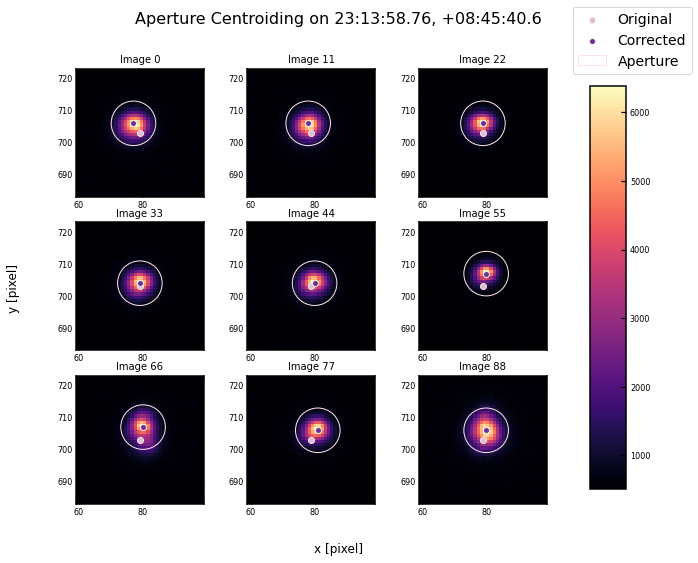

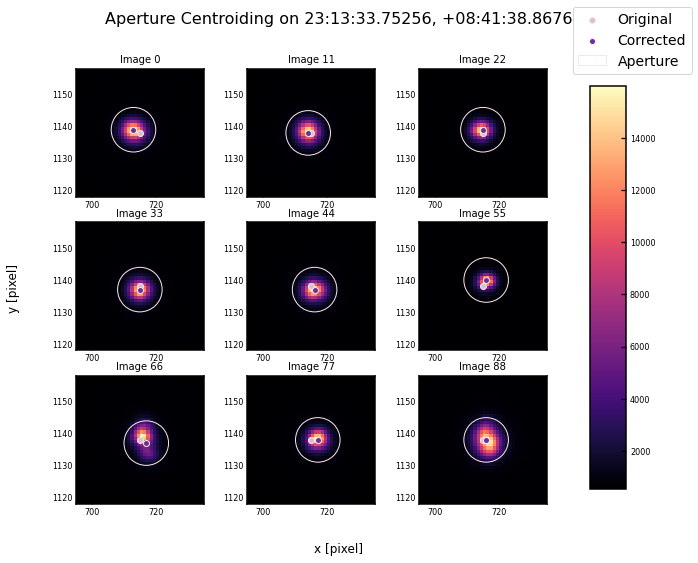

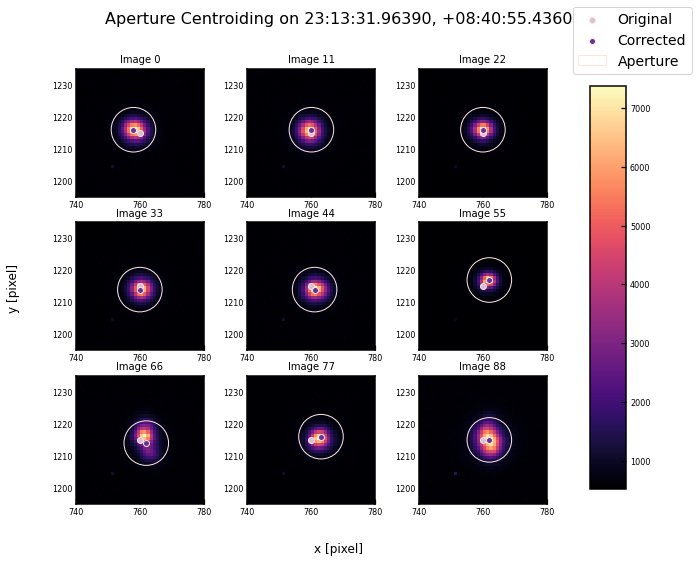

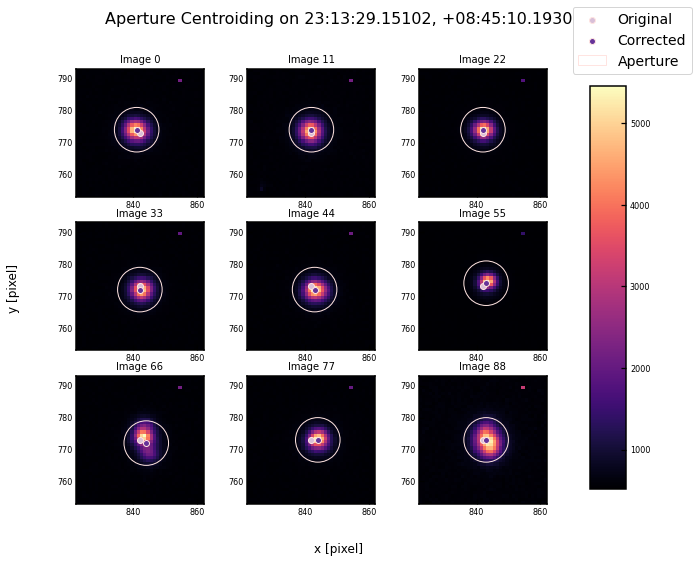

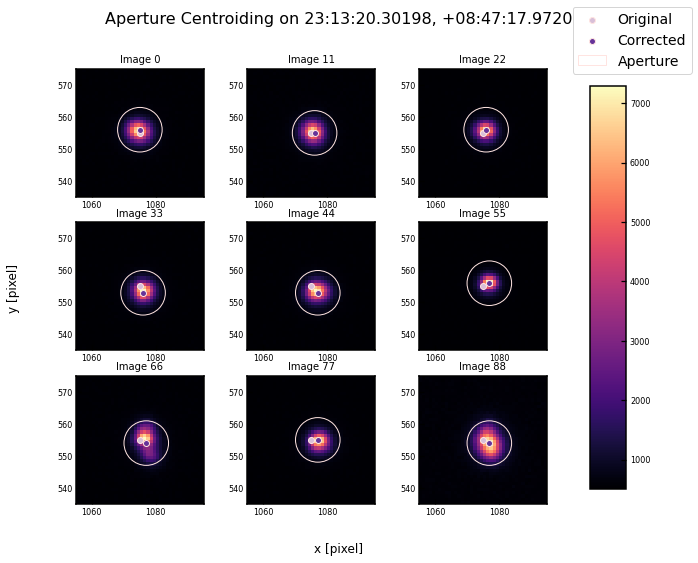

In [4]:
dirtarget = "../data/ps5/WASP-52_WCS"
fil = "r'"
coords = [("23:13:58.76",), ("+08:45:40.6",)]
comp_ra = ["23:13:33.75256", "23:13:31.96390", "23:13:29.15102"]
comp_dec = ["+08:41:38.8676", "+08:40:55.4360", "+08:45:10.1930"]
cra = [("23:13:20.30198",)]
cdec = [("+08:47:17.9720",)]
comp_mags = [11.420, 11.840, 12.270]
aper_rad = None
ann_in_rad = None
ann_out_rad = None
date = "2018-11-07"

aper_sum, comp_apers_return, check_apers, err, check_err, \
        date_obs, altitudes, comp_mags, saturated, exposure_times, \
        centroid_coords, init_coord_list, image_num = photometry(dirtarget, fil, coords, \
                                                                     comp_ra, comp_dec, cra, cdec, comp_mags, \
                                                                     aper_rad, ann_in_rad, ann_out_rad, date, \
                                                                     set_rad=False)

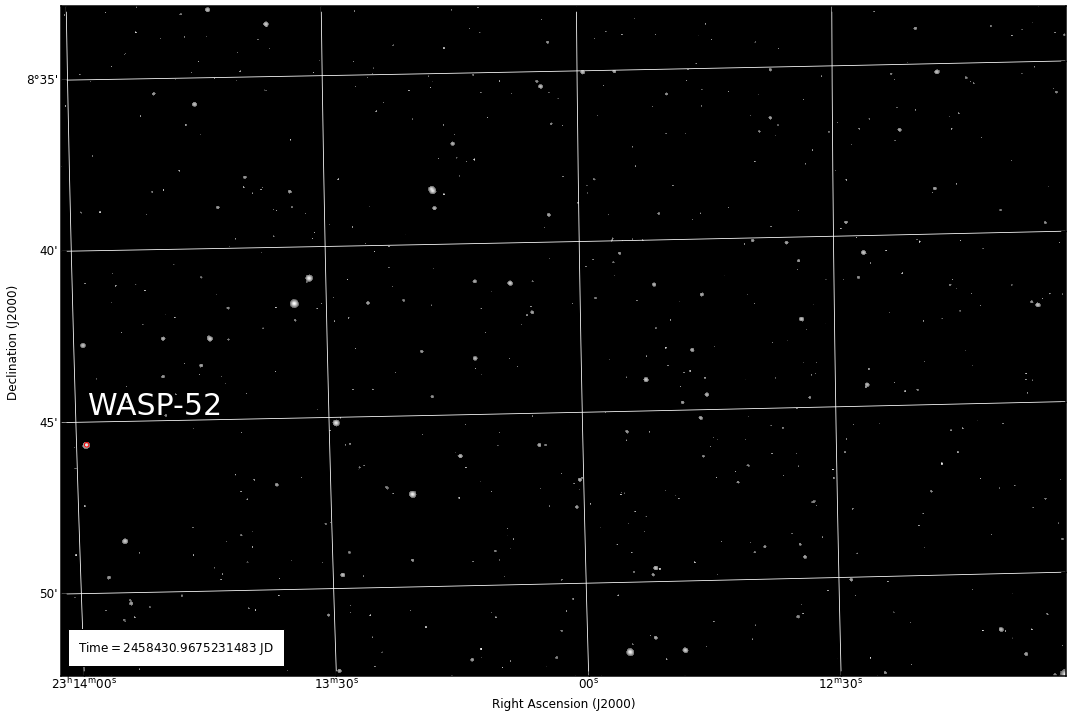

In [5]:
from astropy.visualization import simple_norm

o_file = os.path.join("../data/ps5/WASP-52_WCS/ISR_Images/r'/WCS", "WASP-52_r'_002w.fits")

def plot_fov(o_file):
    hdu = fits.open(o_file)[0]
    header = hdu.header
    data = hdu.data
    
    date = header["DATE"]
    t = Time(date)
    time = t.jd

    hdu.header['CTYPE1'] = "RA---TAN-SIP"
    hdu.header['CTYPE2'] = "DEC--TAN-SIP"

    radius = 4 * u.arcsec
    secpix1 = abs(hdu.header['SECPIX1'])

    w = WCS(header)

    coords = [("23:13:58.76",), ("+08:45:40.6",)]
    ra_i, dec_i = coords[0][0], coords[1][0]
    coords = SkyCoord(ra_i, dec_i, unit=(u.hourangle, u.deg))
    px_dec, py_dec = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1)
    px, py = int(px_dec), int(py_dec)

    star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

    FWHM = 4
    px_cent, py_cent = None, None

    mean, median, std = sigma_clipped_stats(star, sigma=3.0)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std)
    sources = daofind(star - median)
    px_cent = np.average(sources['xcentroid'])
    py_cent = np.average(sources['ycentroid'])

    # Return centroided pixel coordinates.
    x_cent = int(px - 19 + px_cent)
    y_cent = int(py - 19 + py_cent)

    circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
                  fill=False, label='Aperture', ls='-',
                  color='red')

    fig = plt.figure(figsize=(18, 16))

    ax = plt.subplot(projection=w)
    ax.imshow(hdu.data, origin='lower', cmap="gray", norm=simple_norm(hdu.data, stretch='log', min_cut=700, max_cut=20000, log_a=100000))
    ax.add_patch(circ)
    plt.text(80, 800, "WASP-52", color="white", fontsize=30)

    ax.set_xlabel('Right Ascension (J2000)')
    ax.set_ylabel('Declination (J2000)')

    ax.coords.grid(True, color='white', ls='solid')
    ax.text(50, 75, f'$Time={time}~JD$', bbox={'facecolor': 'white', 'pad': 10})

plot_fov(o_file)

In [6]:
def get_image(hdu, time):
    header = hdu.header
    data = hdu.data
    
    radius = 4 * u.arcsec
    secpix1 = abs(hdulist[0].header['SECPIX1'])
    date = header["DATE"]
    t = Time(date)
    time = t.jd

    w = WCS(header)
    
    fig = plt.figure(figsize=(22, 20))
    ax = plt.subplot(projection=w)
    
    ax.imshow(hdu.data, origin='lower', cmap="gray", norm=simple_norm(hdu.data, stretch='log', min_cut=700, max_cut=20000, log_a=100000),
              animated=True)
    
    ax.set_xlabel('Right Ascension (J2000)', fontsize=16)
    ax.set_ylabel('Declination (J2000)', fontsize=16)
    
    ax.text(50, 75, f'$Time={time}~JD$', bbox={'facecolor': 'white', 'pad': 10})

    ax.coords.grid(True, color='white', ls='solid')
    
    display.clear_output(wait=True)
    plt.show()

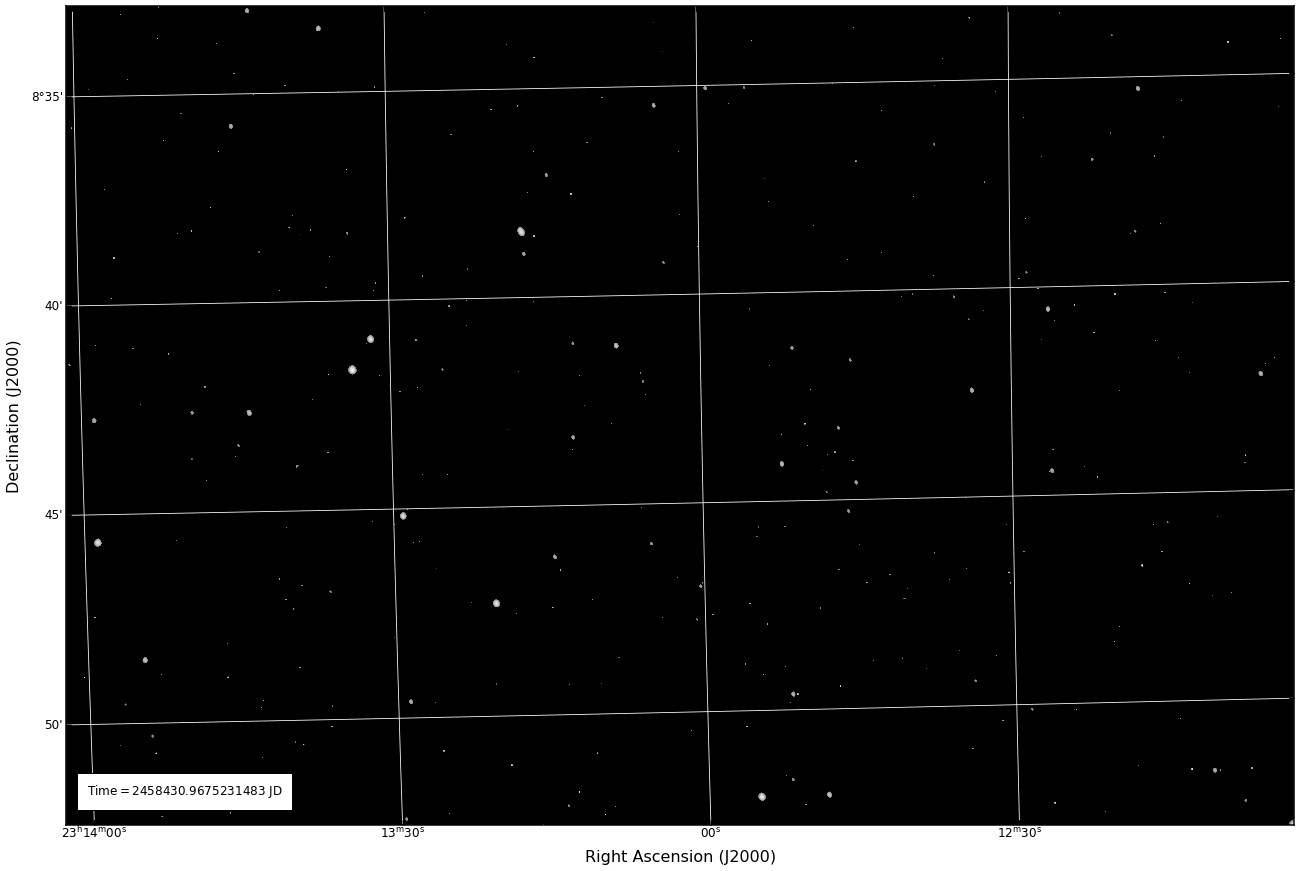

In [8]:
dirtarget = "../data/ps5/WASP-52_WCS"
fil = "r'"
dirtarget_wcs = os.path.join(dirtarget, "ISR_Images", fil, "WCS")
files = sorted(glob.glob(os.path.join(dirtarget_wcs, '*.fits')))
size_files = len(files)

from astropy.io.fits.verify import VerifyWarning
warnings.simplefilter('ignore', category=VerifyWarning)

dates = []
with open(os.path.join(dirtarget, "ISR_Images", fil, "WCS", "output/output_2018-11-07_r'.txt")) as f:
    for line in f:
        if line.startswith("WASP-52"):
            line = line.split(",")
            dates.append(float(line[2]))
          
for i, o_file in enumerate(files):
    hdulist = fits.open(o_file)
    hdu = hdulist[0]
    hdu.header['CTYPE1'] = "RA---TAN-SIP"
    hdu.header['CTYPE2'] = "DEC--TAN-SIP"
    get_image(hdu, dates[i])
    hdulist.close()

Text(50, 75, '$Time=2458430.535277778~JD$')

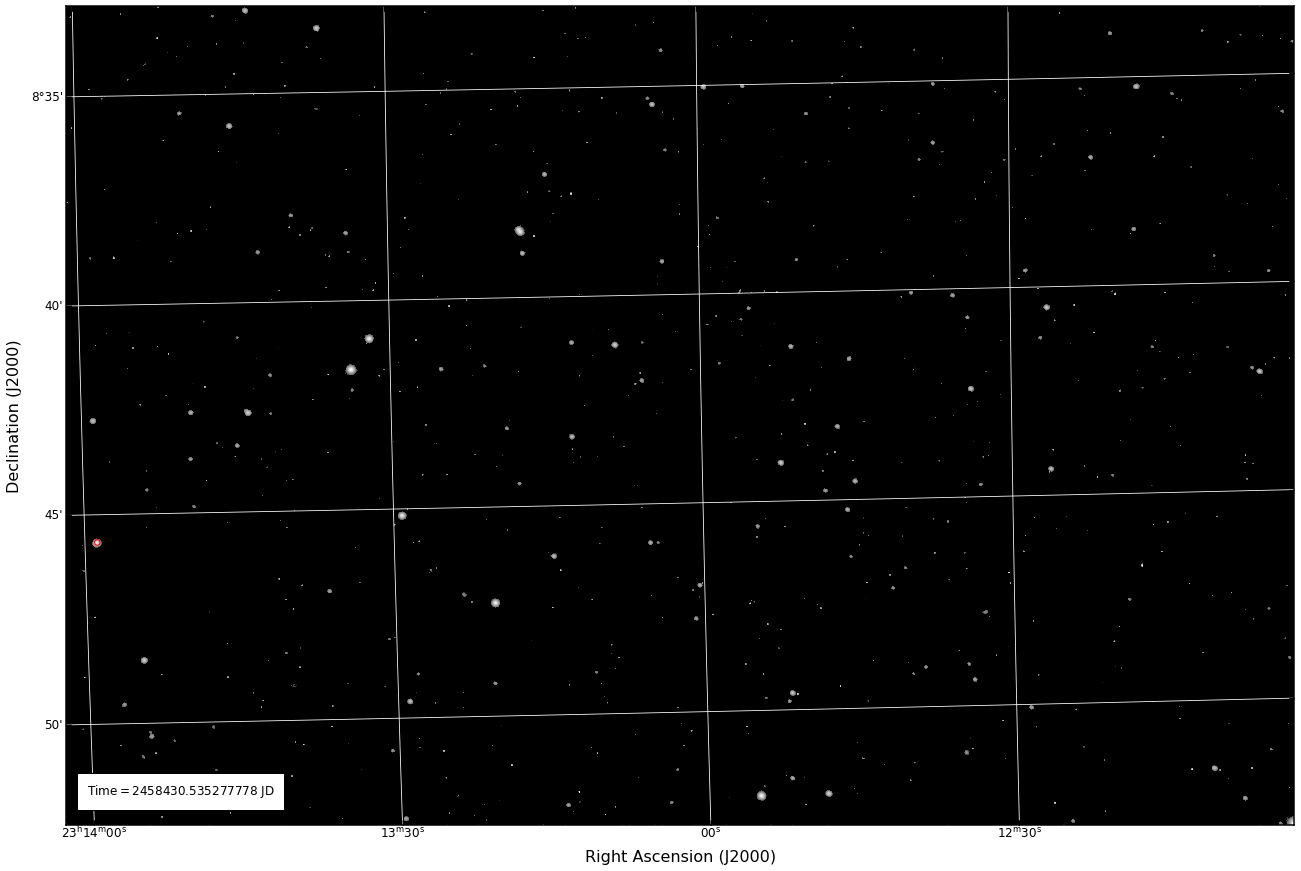

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

o_file = os.path.join("../data/ps5/WASP-52_WCS/ISR_Images/r'/WCS", "WASP-52_r'_002w.fits")
hdu = fits.open(o_file)[0]
header = hdu.header
data = hdu.data

hdu.header['CTYPE1'] = "RA---TAN-SIP"
hdu.header['CTYPE2'] = "DEC--TAN-SIP"
radius = 4 * u.arcsec
secpix1 = abs(hdulist[0].header['SECPIX1'])
            
w = WCS(header)

ra_i, dec_i = coords[0][0], coords[1][0]
coords = SkyCoord(ra_i, dec_i, unit=(u.hourangle, u.deg))
px_dec, py_dec = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1)
px, py = int(px_dec), int(py_dec)

star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

FWHM = 4
px_cent, py_cent = None, None

mean, median, std = sigma_clipped_stats(star, sigma=3.0)
daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std)
sources = daofind(star - median)
px_cent = np.average(sources['xcentroid'])
py_cent = np.average(sources['ycentroid'])

# Return centroided pixel coordinates.
x_cent = int(px - 19 + px_cent)
y_cent = int(py - 19 + py_cent)

circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
              fill=False, label='Aperture', ls='-',
              color='red')

fig = plt.figure(figsize=(22, 20))
ax = plt.subplot(projection=w)
ax.imshow(hdu.data, origin='lower', cmap="gray", norm=simple_norm(hdu.data, stretch='log', min_cut=700, max_cut=20000, log_a=100000))
ax.add_patch(circ)

star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

ax.set_xlabel('Right Ascension (J2000)', fontsize=16)
ax.set_ylabel('Declination (J2000)', fontsize=16)

ax.coords.grid(True, color='white', ls='solid')

ax.text(50, 75, f'$Time={dates[0]}~JD$', bbox={'facecolor': 'white', 'pad': 10})

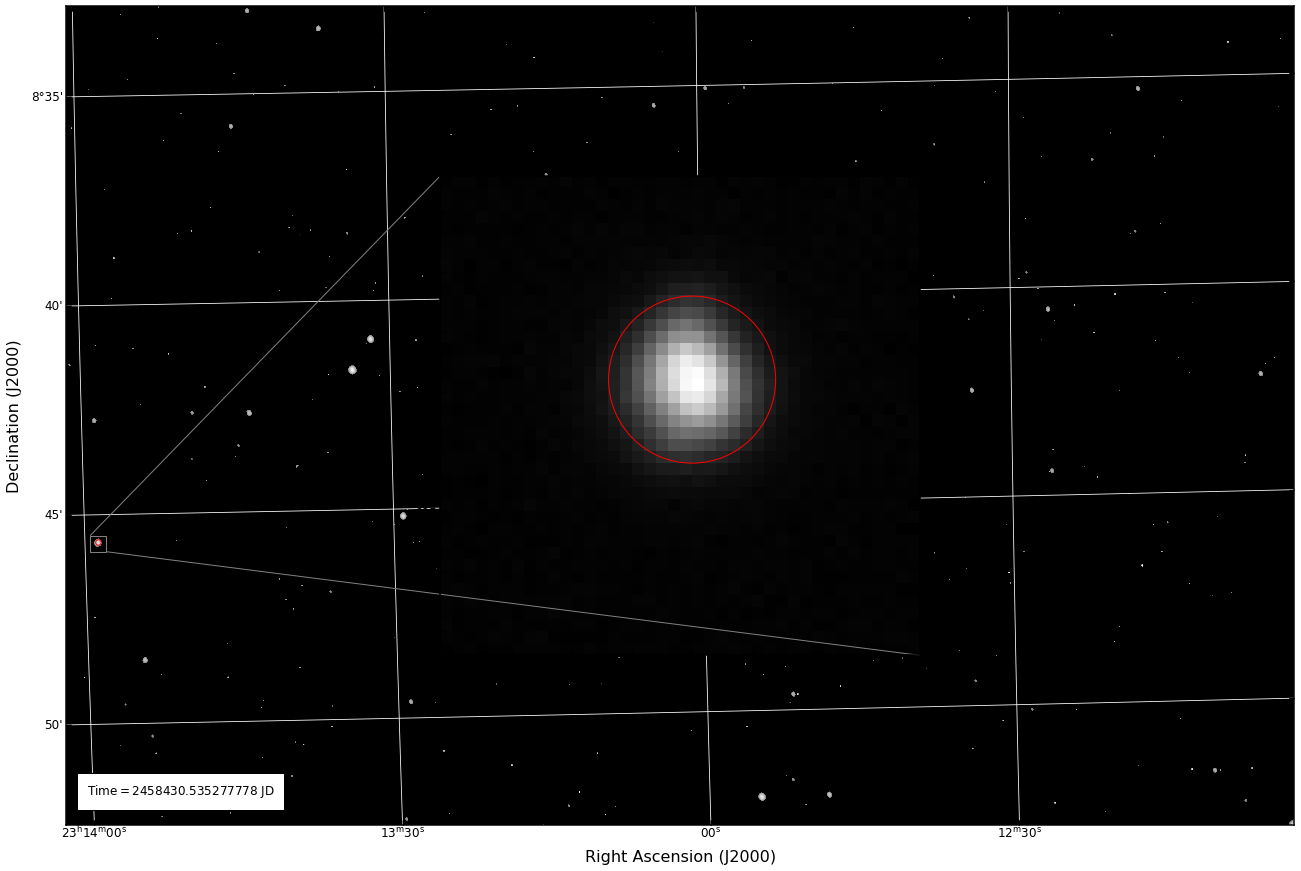

In [11]:
# Includes total animation

dirtarget = "../data/ps5/WASP-52_WCS"
fil = "r'"
dirtarget_wcs = os.path.join(dirtarget, "ISR_Images", fil, "WCS")
files = sorted(glob.glob(os.path.join(dirtarget_wcs, '*.fits')))
size_files = len(files)

from astropy.io.fits.verify import VerifyWarning
warnings.simplefilter('ignore', category=VerifyWarning)

dates = []
with open(os.path.join(dirtarget, "ISR_Images", fil, "WCS", "output/output_2018-11-07_r'.txt")) as f:
    for line in f:
        if line.startswith("WASP-52"):
            line = line.split(",")
            dates.append(float(line[2]))
          
for i, o_file in enumerate(files):
    hdulist = fits.open(o_file)
    hdu = hdulist[0]
    hdu.header['CTYPE1'] = "RA---TAN-SIP"
    hdu.header['CTYPE2'] = "DEC--TAN-SIP"
    get_image(hdu, dates[i])
    hdulist.close()
    
    
    
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

o_file = os.path.join("../data/ps5/WASP-52_WCS/ISR_Images/r'/WCS", "WASP-52_r'_090w.fits")
hdu = fits.open(o_file)[0]
header = hdu.header
data = hdu.data

hdu.header['CTYPE1'] = "RA---TAN-SIP"
hdu.header['CTYPE2'] = "DEC--TAN-SIP"
radius = 4 * u.arcsec
secpix1 = abs(hdulist[0].header['SECPIX1'])
            
w = WCS(header)

coords = SkyCoord(ra_i, dec_i, unit=(u.hourangle, u.deg))
px_dec, py_dec = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1)
px, py = int(px_dec), int(py_dec)

star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

FWHM = 4
px_cent, py_cent = None, None

mean, median, std = sigma_clipped_stats(star, sigma=3.0)
daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std)
sources = daofind(star - median)
px_cent = np.average(sources['xcentroid'])
py_cent = np.average(sources['ycentroid'])

# Return centroided pixel coordinates.
x_cent = int(px - 19 + px_cent)
y_cent = int(py - 19 + py_cent)

circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
              fill=False, label='Aperture', ls='-',
              color='red')

fig = plt.figure(figsize=(22, 20))
ax = plt.subplot(projection=w)
ax.imshow(hdu.data, origin='lower', cmap="gray", norm=simple_norm(hdu.data, stretch='log', min_cut=700, max_cut=20000, log_a=100000))
ax.add_patch(circ)

star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

ax.set_xlabel('Right Ascension (J2000)', fontsize=16)
ax.set_ylabel('Declination (J2000)', fontsize=16)

ax.coords.grid(True, color='white', ls='solid')

ax.text(50, 75, f'$Time={dates[0]}~JD$', bbox={'facecolor': 'white', 'pad': 10})

import time
time.sleep(2)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

def plot_zoomed(zoom):
    o_file = os.path.join("../data/ps5/WASP-52_WCS/ISR_Images/r'/WCS", "WASP-52_r'_090w.fits")
    hdu = fits.open(o_file)[0]
    header = hdu.header
    data = hdu.data

    hdu.header['CTYPE1'] = "RA---TAN-SIP"
    hdu.header['CTYPE2'] = "DEC--TAN-SIP"
    radius = 4 * u.arcsec
    secpix1 = abs(hdulist[0].header['SECPIX1'])

    w = WCS(header)

    coords = SkyCoord(ra_i, dec_i, unit=(u.hourangle, u.deg))
    px_dec, py_dec = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1)
    px, py = int(px_dec), int(py_dec)

    star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

    FWHM = 4
    px_cent, py_cent = None, None

    mean, median, std = sigma_clipped_stats(star, sigma=3.0)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std)
    sources = daofind(star - median)
    px_cent = np.average(sources['xcentroid'])
    py_cent = np.average(sources['ycentroid'])

    # Return centroided pixel coordinates.
    x_cent = int(px - 19 + px_cent)
    y_cent = int(py - 19 + py_cent)

    circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
                  fill=False, label='Aperture', ls='-',
                  color='red')

    fig = plt.figure(figsize=(22, 20))
    ax = plt.subplot(projection=w)
    ax.imshow(hdu.data, origin='lower', cmap="gray", norm=simple_norm(hdu.data, stretch='log', min_cut=700, max_cut=20000, log_a=100000))
    ax.add_patch(circ)

    star = data[(py - 19):(py + 21), (px - 19):(px + 21)]

    axins = zoomed_inset_axes(ax, zoom=zoom, loc=10)
    axins.imshow(star, extent=(px - 19, px + 21, py - 19, py + 21), origin="lower", cmap="gray")
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
                  fill=False, label='Aperture', ls='-',
                  color='red')
    axins.add_patch(circ)

    ax.set_xlabel('Right Ascension (J2000)', fontsize=16)
    ax.set_ylabel('Declination (J2000)', fontsize=16)

    ax.coords.grid(True, color='white', ls='solid')

    ax.text(50, 75, f'$Time={dates[0]}~JD$', bbox={'facecolor': 'white', 'pad': 10})
    display.clear_output(wait=True)
    plt.show()

zooms = np.linspace(1, 30, 30)
for zoom in zooms:
    plot_zoomed(zoom)

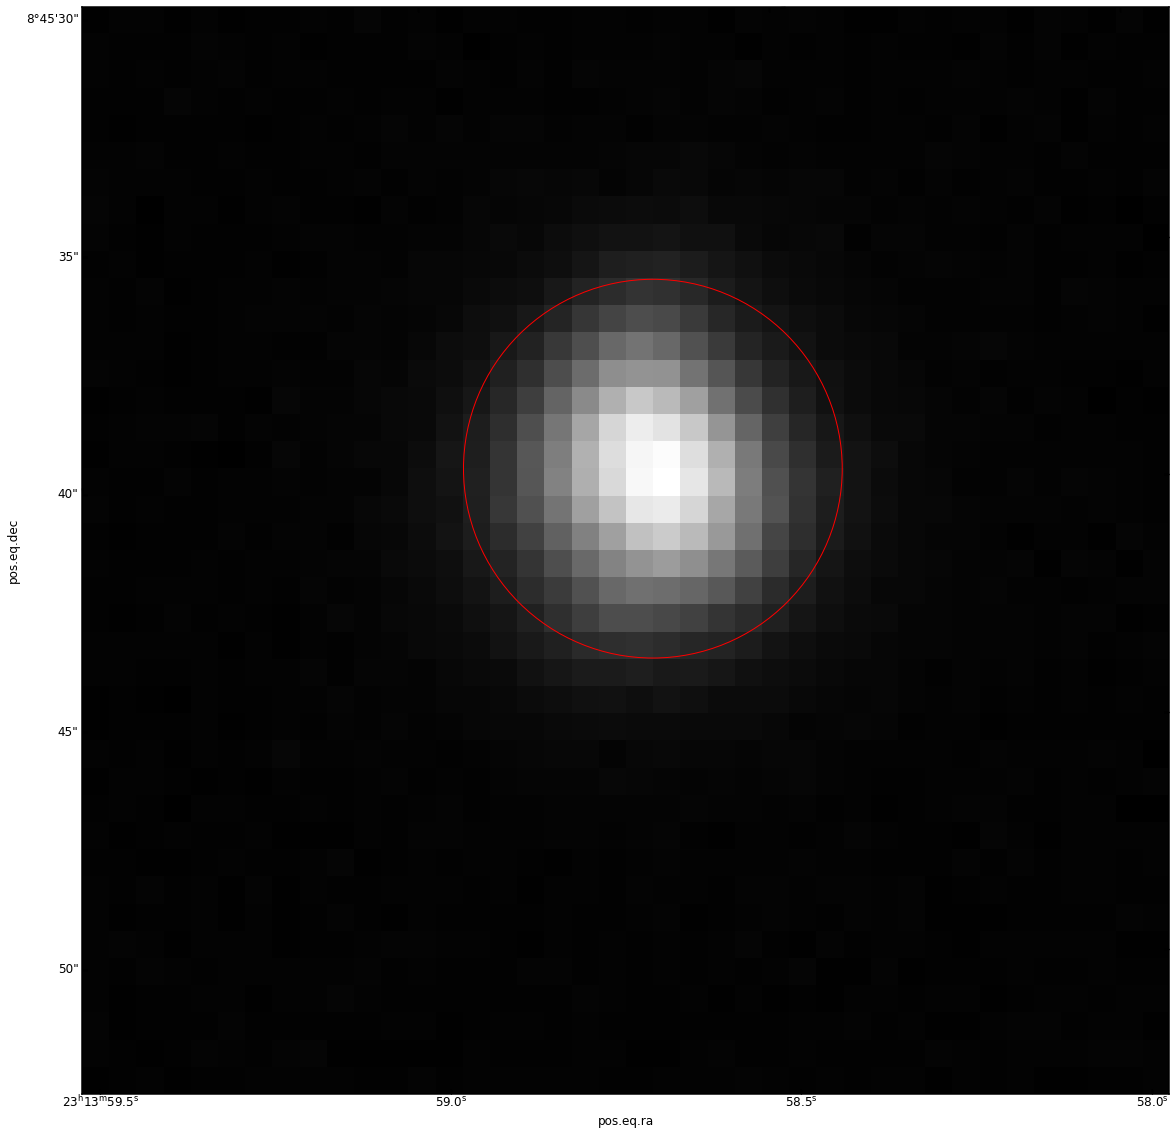

In [12]:
fig = plt.figure(figsize=(22, 20))
ax = plt.subplot(projection=w)
circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
              fill=False, label='Aperture', ls='-',
              color='red')
ax.add_patch(circ)
ax.imshow(star, extent=(px - 19, px + 21, py - 19, py + 21), origin="lower", cmap="gray")

In [13]:
def plot_psf(path, x, y, angle):
    data = np.array(fits.getdata(path))

    x_lb = int(x - 15)
    x_ub = int(x + 15)
    y_lb = int(y - 15)
    y_ub = int(y + 15)

    region = np.array(data[y_lb:y_ub, x_lb:x_ub])

    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')
    #
    # Create an X-Y mesh of the same dimension as the 2D data. You can
    # think of this as the floor of the plot.
    #
    x_data, y_data = np.meshgrid(np.arange(region.shape[1]),
                                 np.arange(region.shape[0]))
    #
    # Flatten out the arrays so that they may be passed to "ax.bar3d".
    # Basically, ax.bar3d expects three one-dimensional arrays:
    # x_data, y_data, z_data. The following call boils down to picking
    # one entry from each array and plotting a bar to from
    # (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
    #
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = region.flatten()
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), 1, 1, z_data, color="white")

    path_file = os.path.split(os.path.abspath(path))
    path = path_file[0]
    filename = path_file[1]
    filechars = np.array(list(filename))
    n = np.where(filechars == '.')[0][0]
    #
    # Finally, display the plot.
    #
    plt.title("{} 3D Histogram Centered at ({}, {})".format(filename, x, y))

    filename = filename[:n]
    
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.axis('off')
    ax.view_init(theta, 30)
    display.clear_output(wait=True)
    plt.show()
    
def plot_psf_rot(path, x, y, angle, theta_p):
    data = np.array(fits.getdata(path))

    x_lb = int(x - 15)
    x_ub = int(x + 15)
    y_lb = int(y - 15)
    y_ub = int(y + 15)

    region = np.array(data[y_lb:y_ub, x_lb:x_ub])

    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')
    #
    # Create an X-Y mesh of the same dimension as the 2D data. You can
    # think of this as the floor of the plot.
    #
    x_data, y_data = np.meshgrid(np.arange(region.shape[1]),
                                 np.arange(region.shape[0]))
    #
    # Flatten out the arrays so that they may be passed to "ax.bar3d".
    # Basically, ax.bar3d expects three one-dimensional arrays:
    # x_data, y_data, z_data. The following call boils down to picking
    # one entry from each array and plotting a bar to from
    # (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
    #
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = region.flatten()
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), 1, 1, z_data, color="white")

    path_file = os.path.split(os.path.abspath(path))
    path = path_file[0]
    filename = path_file[1]
    filechars = np.array(list(filename))
    n = np.where(filechars == '.')[0][0]
    #
    # Finally, display the plot.
    #
    plt.title("{} 3D Histogram Centered at ({}, {})".format(filename, x, y))

    filename = filename[:n]
    
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.axis('off')
    ax.view_init(theta, theta_p)
    display.clear_output(wait=True)
    plt.show()

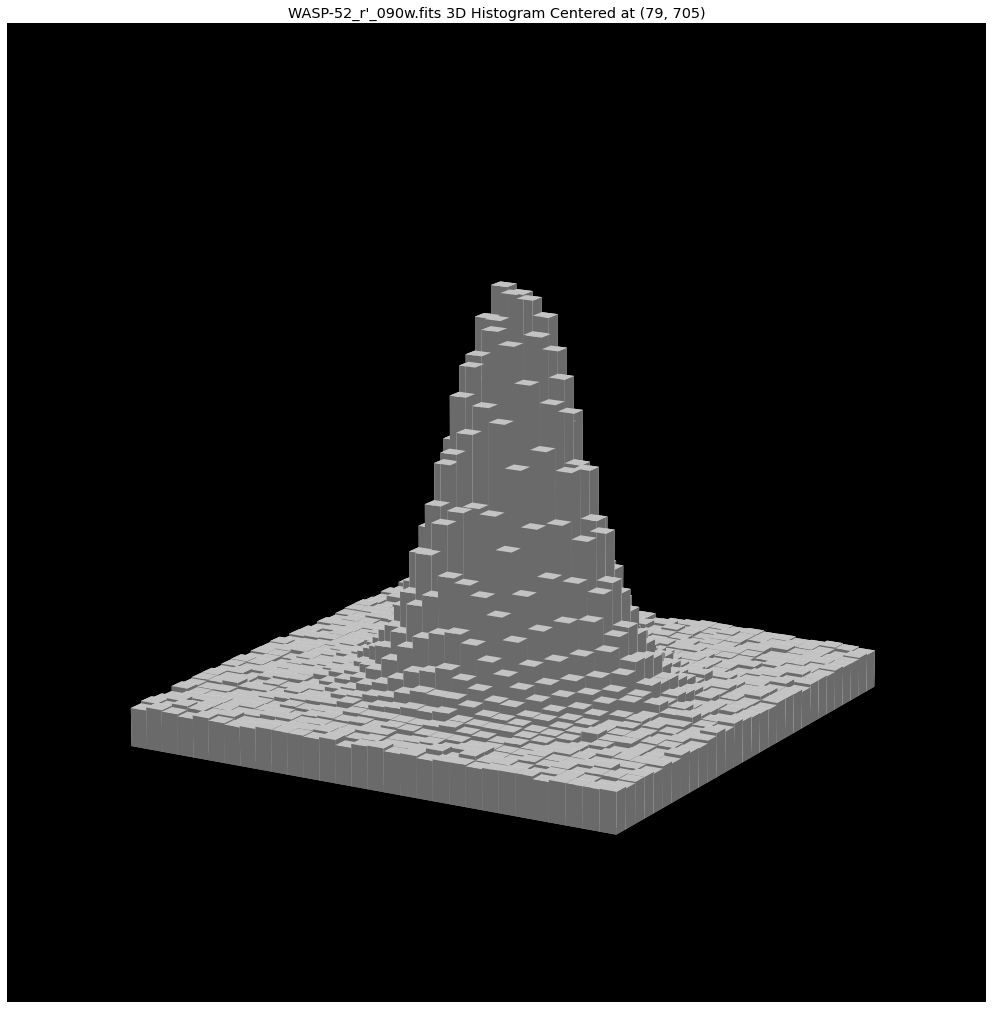

In [14]:
thetas = np.linspace(90, 15, 30)
theta_p = np.linspace(30, 30+360, 45)

o_file = os.path.join("../data/ps5/WASP-52_WCS/ISR_Images/r'/WCS", "WASP-52_r'_090w.fits")
theta = None
for theta in thetas:
    plot_psf(o_file, x_cent, y_cent, theta)
for alpha in theta_p:
    plot_psf_rot(o_file, x_cent, y_cent, theta, alpha)

In [15]:
def plot_psf_p(path, x, y, angle, ax):
    data = np.array(fits.getdata(path))

    x_lb = int(x - 15)
    x_ub = int(x + 15)
    y_lb = int(y - 15)
    y_ub = int(y + 15)

    region = np.array(data[y_lb:y_ub, x_lb:x_ub])
    #
    # Create an X-Y mesh of the same dimension as the 2D data. You can
    # think of this as the floor of the plot.
    #
    x_data, y_data = np.meshgrid(np.arange(region.shape[1]),
                                 np.arange(region.shape[0]))
    # Flatten out the arrays so that they may be passed to "ax.bar3d".
    # Basically, ax.bar3d expects three one-dimensional arrays:
    # x_data, y_data, z_data. The following call boils down to picking
    # one entry from each array and plotting a bar to from
    # (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
    #
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = region.flatten()
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), 1, 1, z_data, color="white")

    path_file = os.path.split(os.path.abspath(path))
    path = path_file[0]
    filename = path_file[1]
    filechars = np.array(list(filename))
    n = np.where(filechars == '.')[0][0]
    #
    # Finally, display the plot.
    #

    filename = filename[:n]
    
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.axis('off')
    ax.view_init(25, 30)

In [16]:
def subplot_photometry(o_file, radius, centroid_table, date, mag, err):
    hdu = fits.open(o_file)[0]
    header = hdu.header
    data = hdu.data
    x_cent = int(centroid_table[3])
    y_cent = int(centroid_table[4])

    plt.figure(figsize=(20,22), facecolor="black")
    plt.tight_layout()
    
    ax = plt.subplot(2, 2, 1)
    ax.set_facecolor('black')
    
    # Define source region as a 20x20 square centered at (px,py)
    star = data[(y_cent - 19):(y_cent + 21), (x_cent - 19):(x_cent + 21)]
    circ = Circle((x_cent+1, y_cent+1), radius.value/secpix1,
                  fill=False, label='Aperture', ls='-',
                  color='red')
    ax.add_patch(circ)
    ax.imshow(star, extent=(x_cent - 19, x_cent + 21, y_cent - 19, y_cent + 21), origin="lower", cmap="gray")
    
    
    ax = plt.subplot(2, 1, 2)
    ax.set_xlabel('Time [JD]', fontsize=16)
    ax.set_ylabel(f"$r' Magnitude~[mag]$", fontsize=16)
    ax.set_facecolor('black')
    ax.errorbar(date, mag, yerr=err, fmt="o", c="white")
    ax.set_xlim(np.amin(dates), np.amax(dates))
    ax.set_ylim(12.0, 12.06)
    ax.invert_yaxis()
    ax.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color('white')          #setting up Y-axis label color to blue

    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

    ax.spines['left'].set_color('white')        # setting up Y-axis tick color to red
    ax.spines['top'].set_color('white') 
    ax.spines['bottom'].set_color('white') 
    ax.spines['right'].set_color('white') 
    
    
    ax = plt.subplot(2, 2, 2, projection="3d")
    plot_psf_p(o_file, x_cent, y_cent, 45, ax)
    
    display.clear_output(wait=True)
    plt.show()

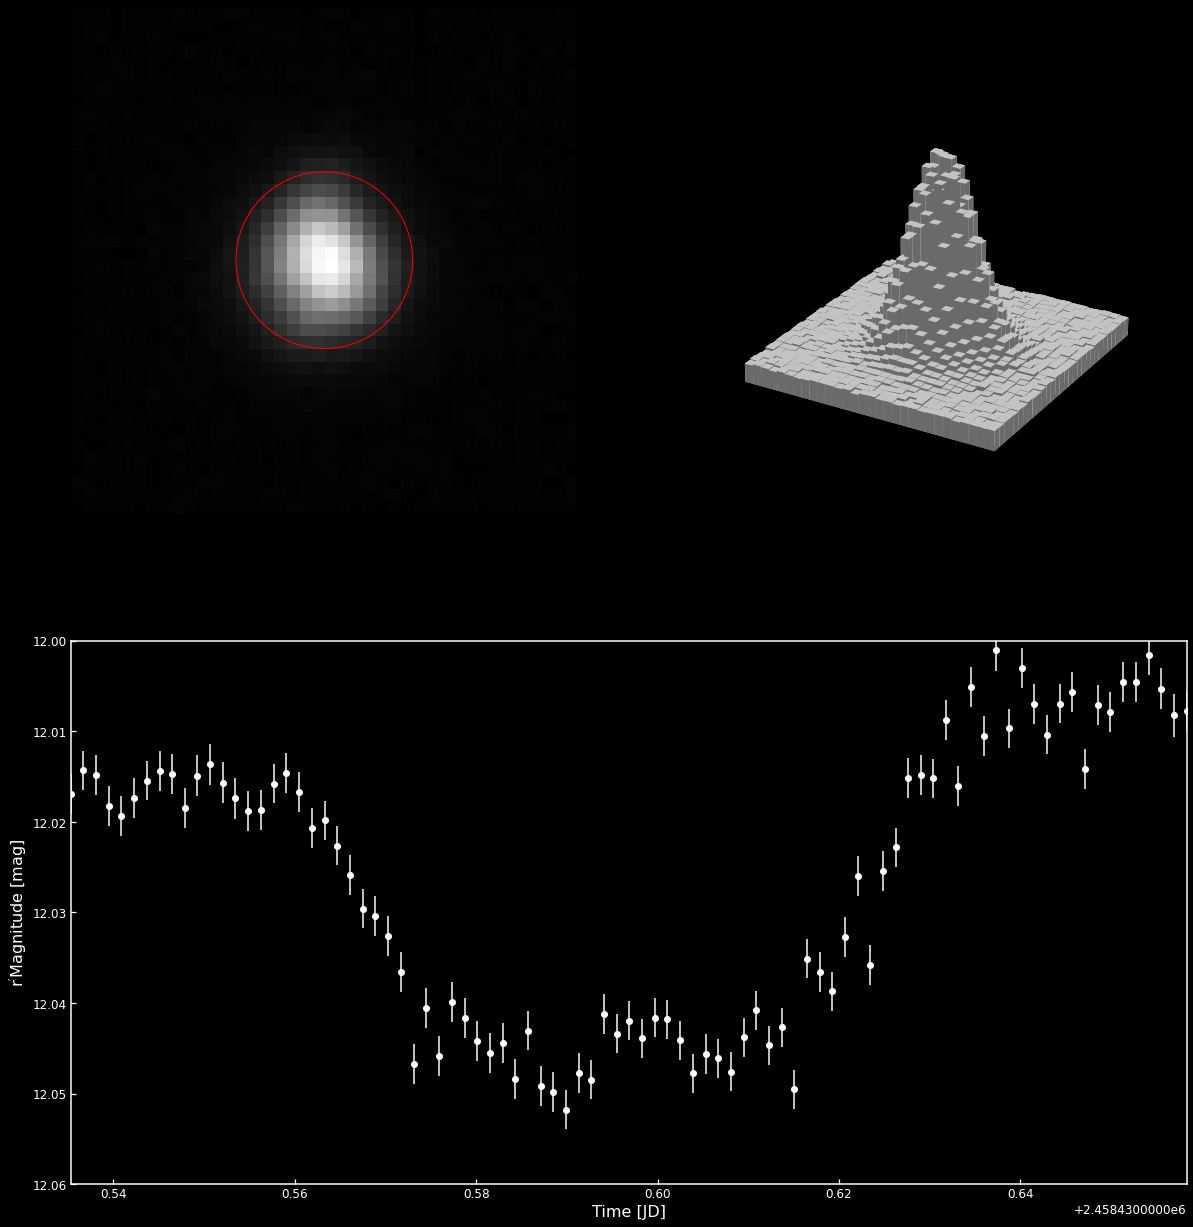

In [17]:
output_file = []
with open(os.path.join("/Users/helenarichie/Downloads", "output_2018-11-07.txt")) as f:
    for line in f:
        if line.startswith("WASP-52"):
            line = line.split(",")
            output_file.append(line)

centroid_table = []
with open(os.path.join(dirtarget, "ISR_Images", fil, "WCS", "output/centroid_2018-11-07_r'.txt")) as f:
    for line in f:
        if line.startswith(""):
            line = line.split(",")
            centroid_table.append(line)
            
centroid_table = centroid_table[2:]

date, mag, err = [], [], []
for i, o_file in enumerate(files):
    date.append(float(output_file[i][1]))
    mag.append(float(output_file[i][2]))
    err.append(float(output_file[i][3]))
    subplot_photometry(o_file, radius, centroid_table[i], date, mag, err)